# Deep Convolutional GAN (DCGAN)

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        # x = self.unsqueeze_noise(noise)
        return self.gen(noise)

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim,1,1).to(device)

In [5]:
get_noise(16,100).shape

torch.Size([16, 100, 1, 1])

Here's the test for your generator block:

In [6]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                ### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        # disc_pred = self.disc(image)
        return self.disc(image)

In [7]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
#
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [8]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

Then, you can initialize your generator, discriminator, and optimizers.

In [9]:


# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, you can train your GAN!
For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. You might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse: 
![MNIST Digits Progression](MNIST_DCGAN_Progression.png)


  7%|▋         | 31/469 [00:01<00:14, 30.60it/s]

Step 500: Generator loss: 1.0728321855068208, discriminator loss: 0.4621344283223149


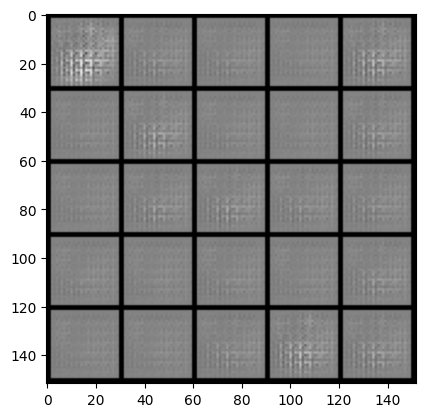

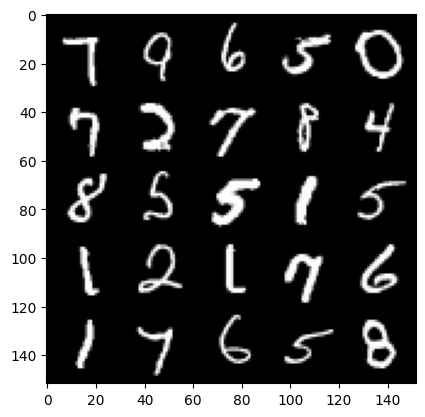

 13%|█▎        | 60/469 [00:02<00:14, 28.85it/s]

Step 1000: Generator loss: 2.3043851723670943, discriminator loss: 0.21330502604693172


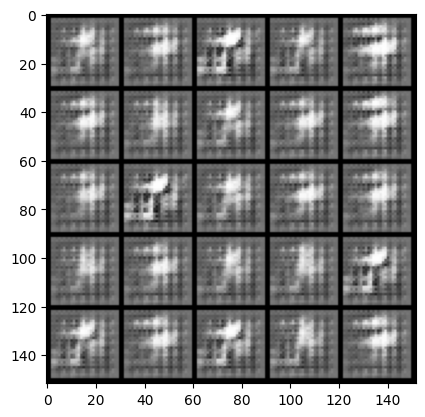

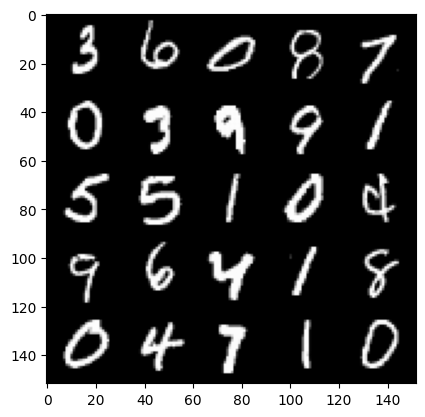

 20%|█▉        | 93/469 [00:03<00:13, 28.78it/s]

Step 1500: Generator loss: 1.5741960974037652, discriminator loss: 0.42942860472202293


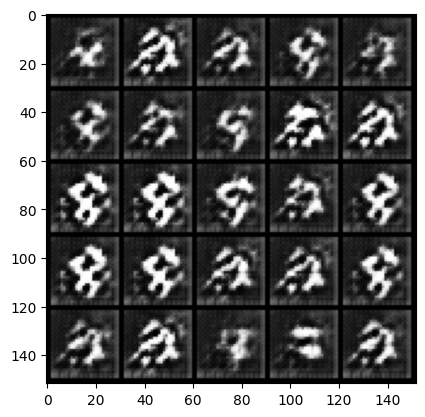

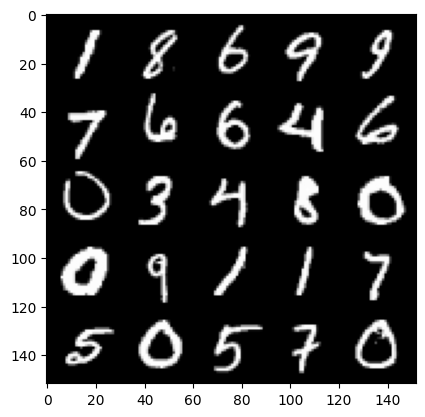

 26%|██▋       | 124/469 [00:04<00:12, 28.68it/s]

Step 2000: Generator loss: 1.0766070966124532, discriminator loss: 0.5398966278433801


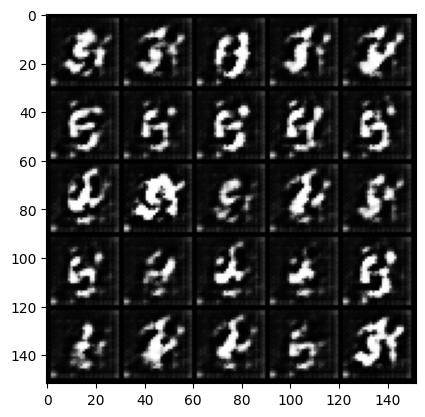

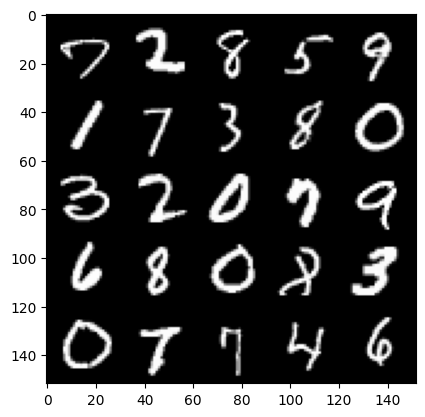

 33%|███▎      | 153/469 [00:05<00:11, 28.57it/s]

Step 2500: Generator loss: 0.9644511404037479, discriminator loss: 0.5776163186430933


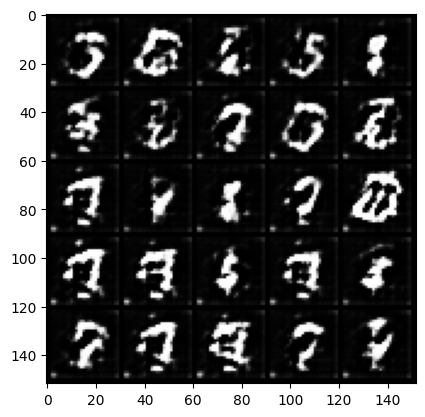

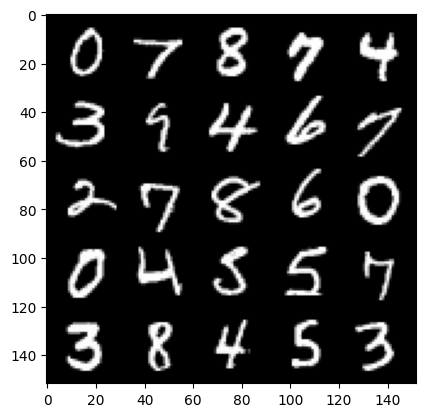

 39%|███▉      | 185/469 [00:06<00:09, 29.21it/s]

Step 3000: Generator loss: 0.8953987224698061, discriminator loss: 0.5950885648727413


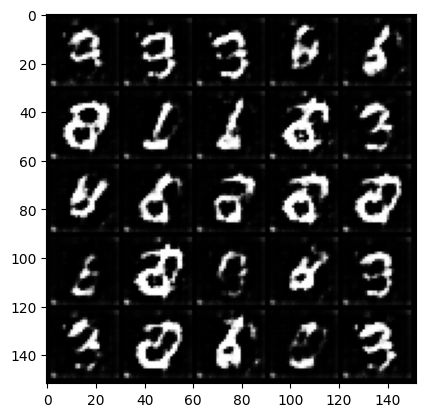

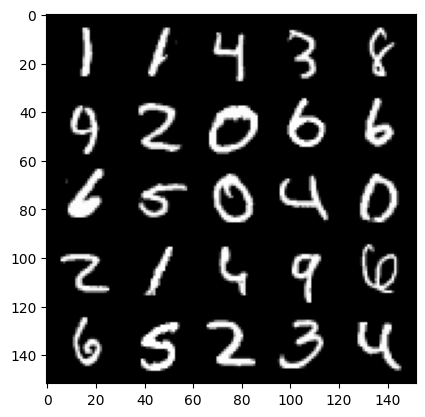

 46%|████▋     | 217/469 [00:07<00:08, 28.28it/s]

Step 3500: Generator loss: 0.8789646953344344, discriminator loss: 0.6093739882707593


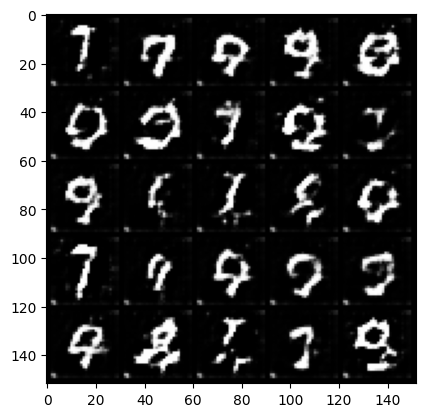

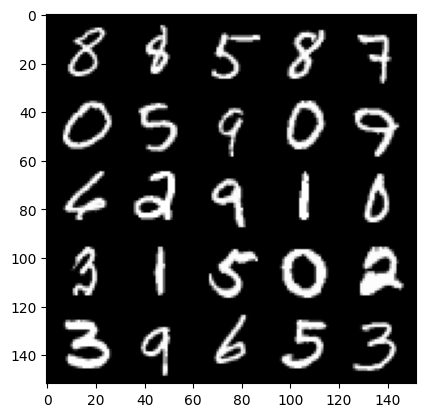

 52%|█████▏    | 246/469 [00:09<00:07, 29.03it/s]

Step 4000: Generator loss: 0.8547194918990145, discriminator loss: 0.6216151609420781


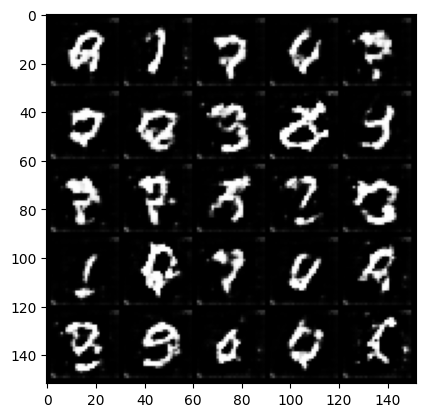

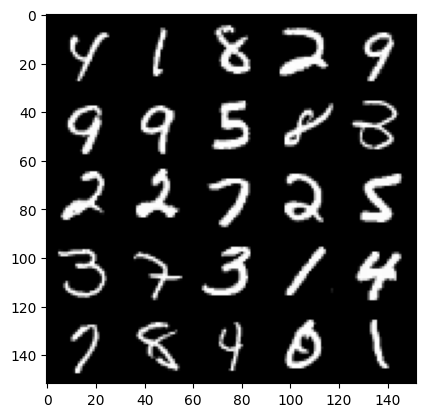

 59%|█████▉    | 276/469 [00:09<00:06, 30.46it/s]

Step 4500: Generator loss: 0.8190410891771319, discriminator loss: 0.6394740478992458


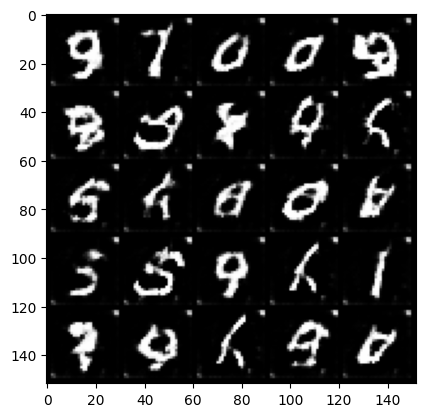

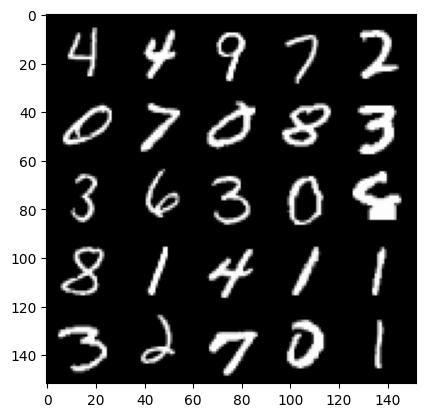

 66%|██████▌   | 310/469 [00:10<00:05, 30.55it/s]

Step 5000: Generator loss: 0.8020148088335998, discriminator loss: 0.6526008638143543


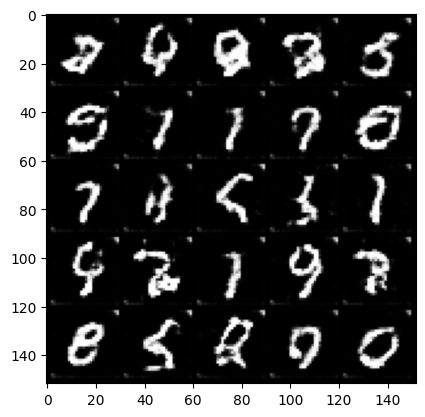

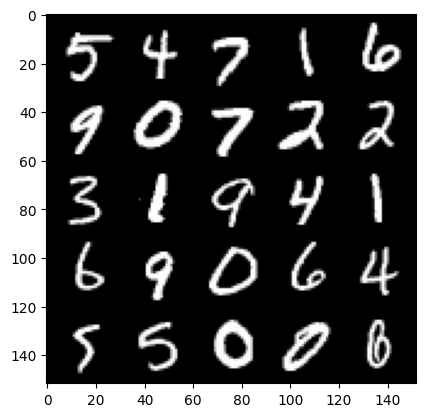

 73%|███████▎  | 341/469 [00:11<00:04, 30.10it/s]

Step 5500: Generator loss: 0.7836419333815572, discriminator loss: 0.6605547266006464


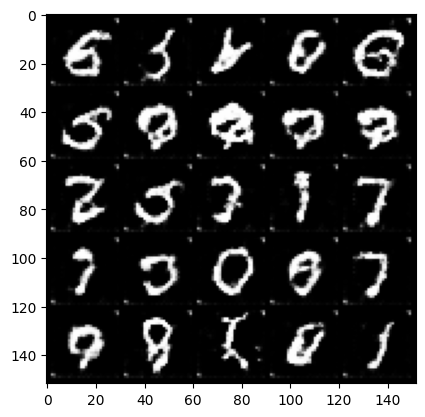

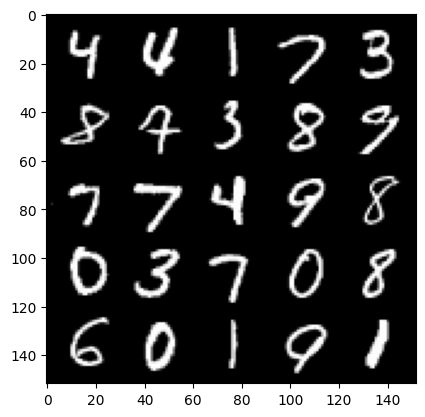

 79%|███████▉  | 372/469 [00:12<00:03, 29.97it/s]

Step 6000: Generator loss: 0.7742873650789263, discriminator loss: 0.6680669847726821


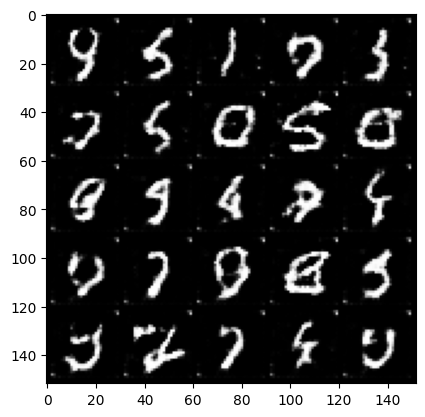

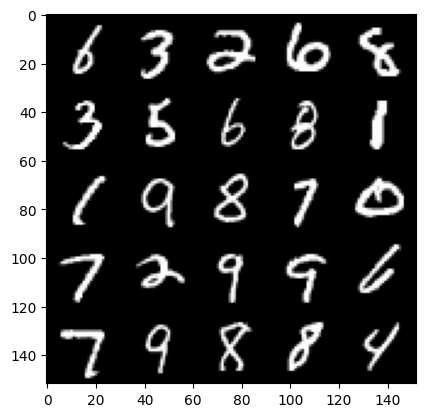

 85%|████████▌ | 400/469 [00:13<00:02, 28.97it/s]

Step 6500: Generator loss: 0.7601517995595936, discriminator loss: 0.6686066190004349


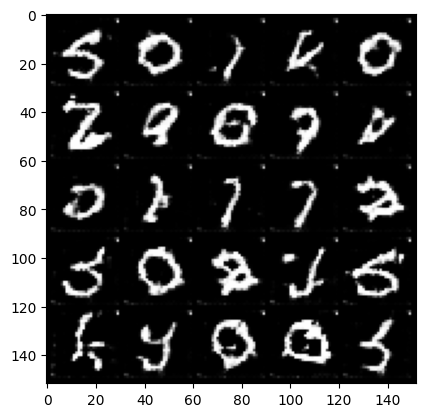

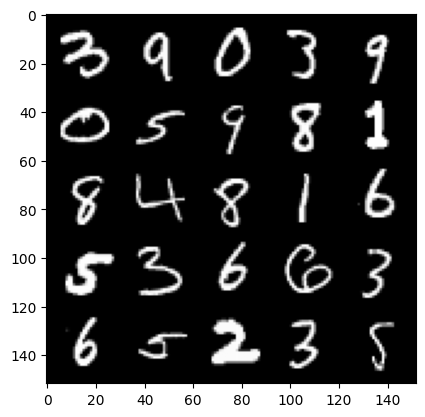

 92%|█████████▏| 432/469 [00:15<00:01, 29.72it/s]

Step 7000: Generator loss: 0.7535461047887808, discriminator loss: 0.6714738589525221


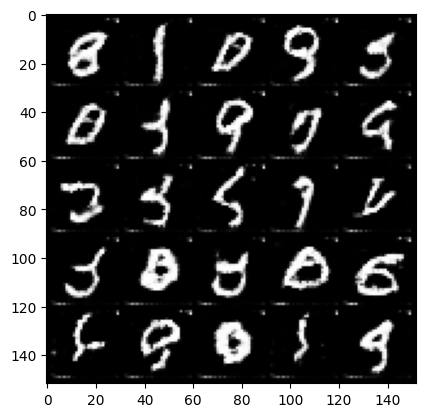

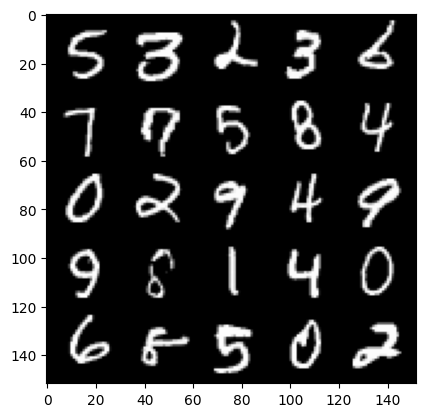

 99%|█████████▊| 462/469 [00:15<00:00, 30.98it/s]

Step 7500: Generator loss: 0.7482196226716044, discriminator loss: 0.6738539165258407


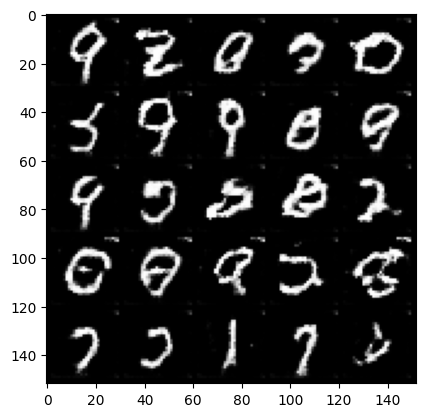

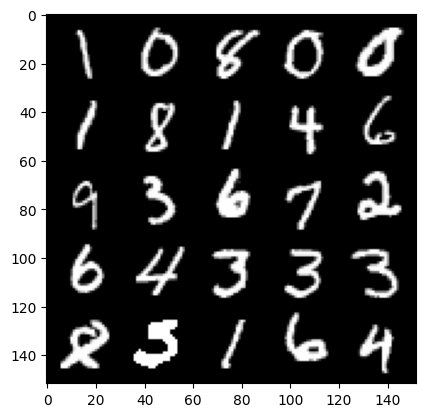

  6%|▌         | 26/469 [00:00<00:14, 30.71it/s]

Step 8000: Generator loss: 0.7506982955336569, discriminator loss: 0.6762664670944216


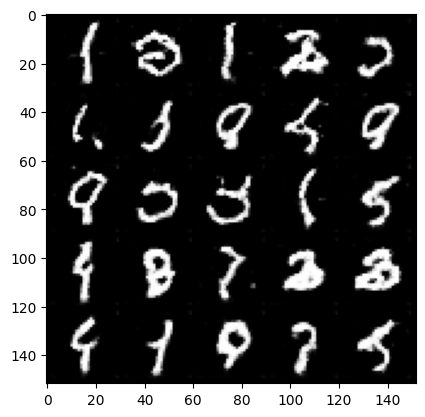

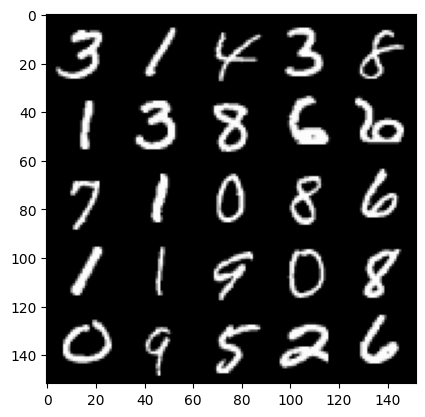

 12%|█▏        | 58/469 [00:01<00:14, 28.82it/s]

Step 8500: Generator loss: 0.7467635051012036, discriminator loss: 0.6821649808883659


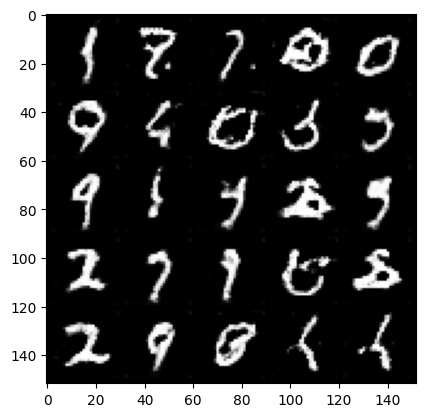

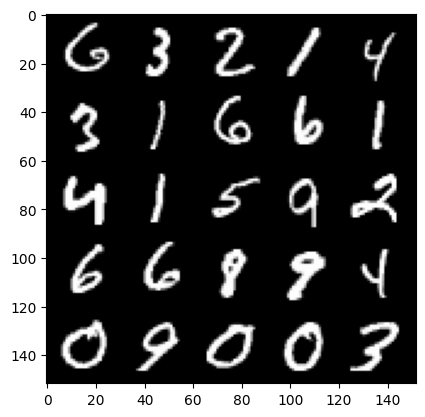

 18%|█▊        | 86/469 [00:02<00:12, 30.04it/s]

Step 9000: Generator loss: 0.736789948403836, discriminator loss: 0.6849042069911961


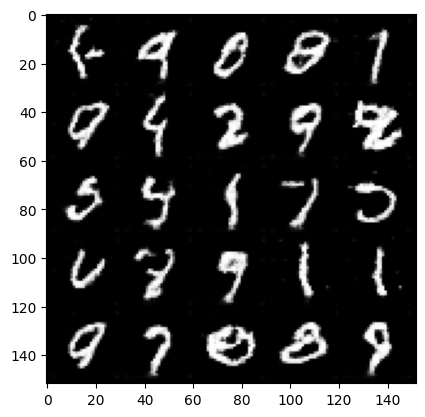

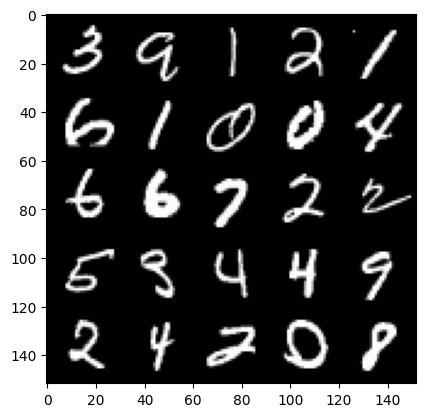

 25%|██▍       | 117/469 [00:03<00:11, 30.93it/s]

Step 9500: Generator loss: 0.7372146035432814, discriminator loss: 0.6863219836950303


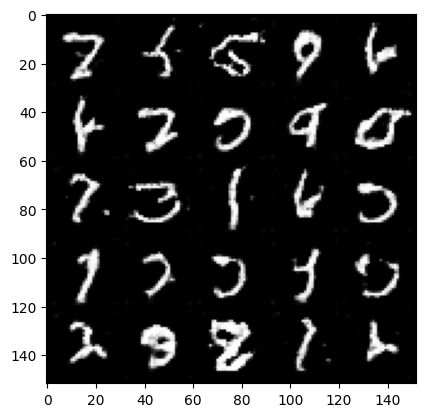

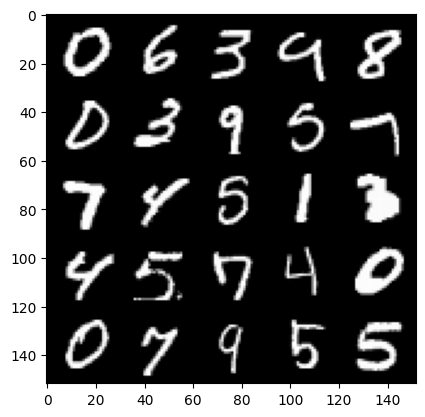

 32%|███▏      | 149/469 [00:04<00:10, 29.61it/s]

Step 10000: Generator loss: 0.7254841764569281, discriminator loss: 0.6927089196443558


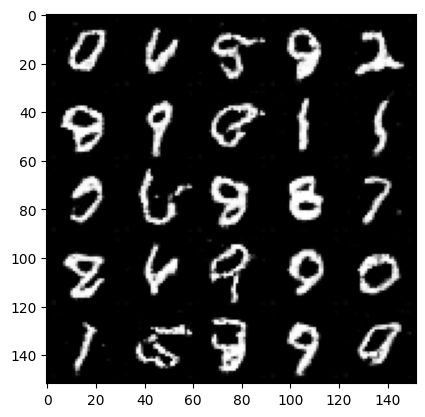

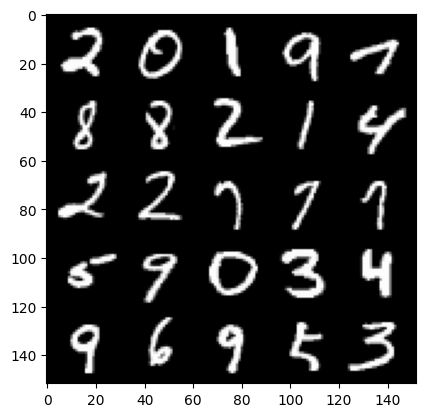

 38%|███▊      | 180/469 [00:06<00:09, 30.58it/s]

Step 10500: Generator loss: 0.7264952804446217, discriminator loss: 0.6897687215805055


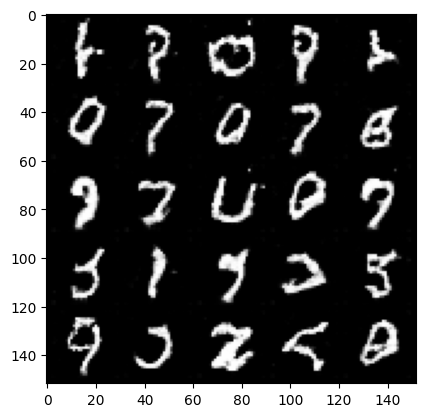

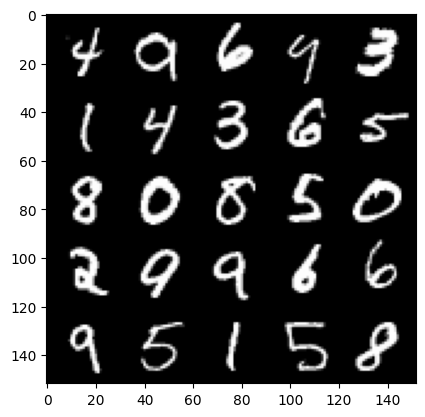

 45%|████▌     | 212/469 [00:06<00:08, 30.72it/s]

Step 11000: Generator loss: 0.723769618034363, discriminator loss: 0.6922811425924299


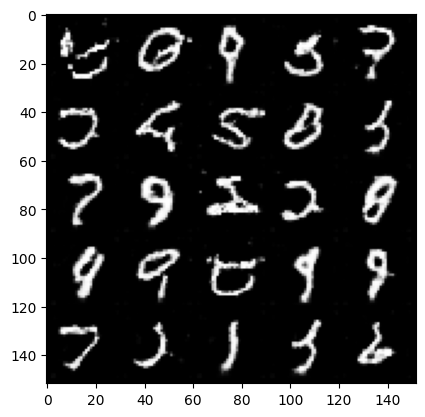

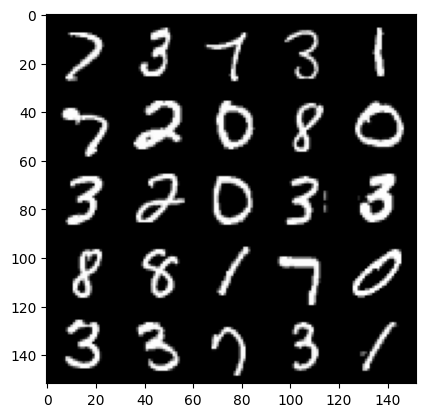

 52%|█████▏    | 242/469 [00:08<00:07, 28.77it/s]

Step 11500: Generator loss: 0.7195712590217588, discriminator loss: 0.6937914063930508


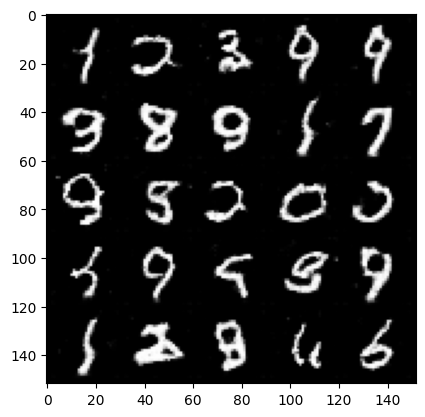

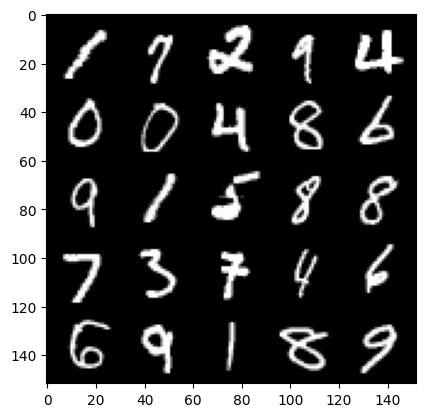

 58%|█████▊    | 273/469 [00:09<00:06, 29.30it/s]

Step 12000: Generator loss: 0.719529979586601, discriminator loss: 0.6947420704364774


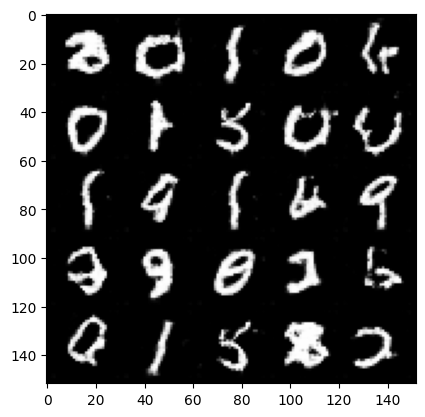

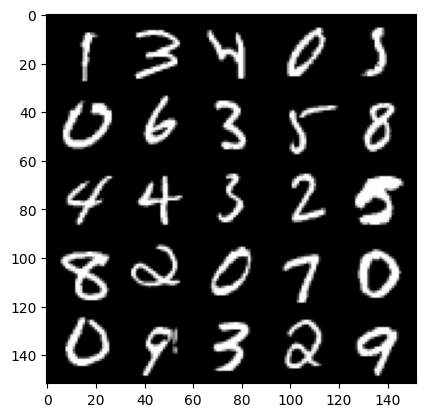

 65%|██████▍   | 303/469 [00:10<00:05, 29.46it/s]

Step 12500: Generator loss: 0.7174247158169752, discriminator loss: 0.6933250447511674


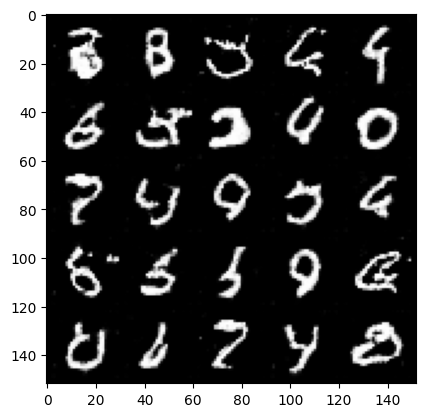

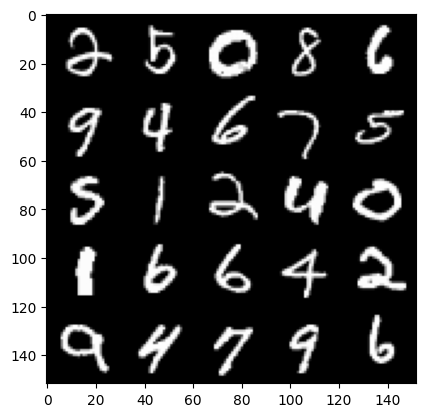

 71%|███████   | 334/469 [00:10<00:04, 30.96it/s]

Step 13000: Generator loss: 0.7178658655285831, discriminator loss: 0.6934363175630568


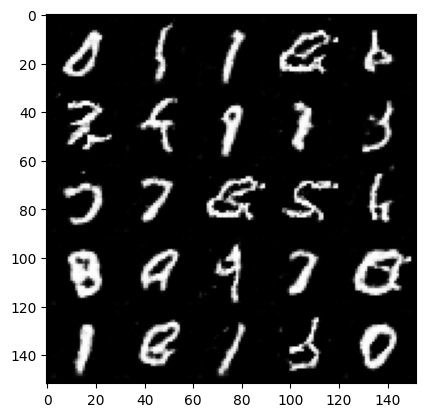

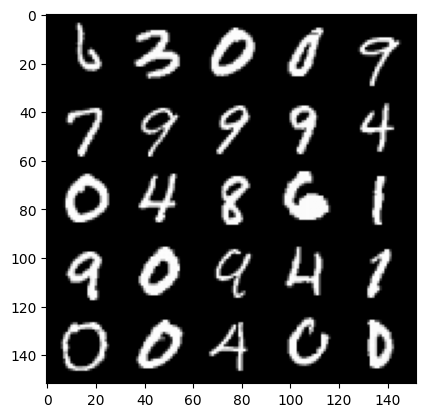

 78%|███████▊  | 368/469 [00:12<00:03, 28.89it/s]

Step 13500: Generator loss: 0.7159892936944965, discriminator loss: 0.6941762037277222


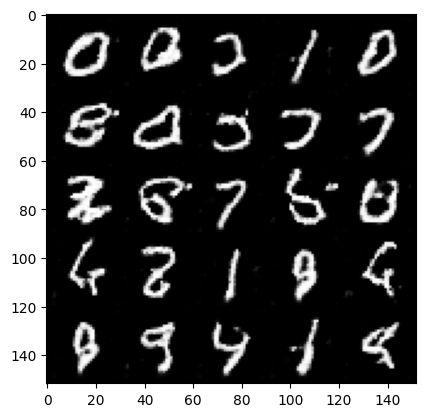

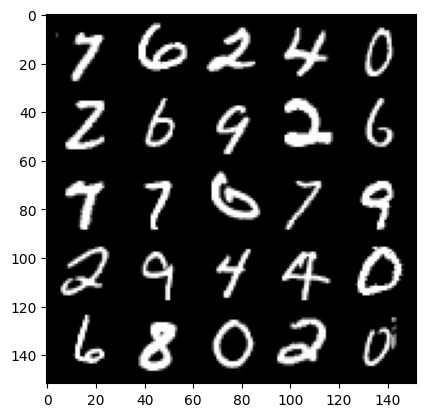

 85%|████████▍ | 397/469 [00:13<00:02, 30.19it/s]

Step 14000: Generator loss: 0.7137712068557739, discriminator loss: 0.6953058739900593


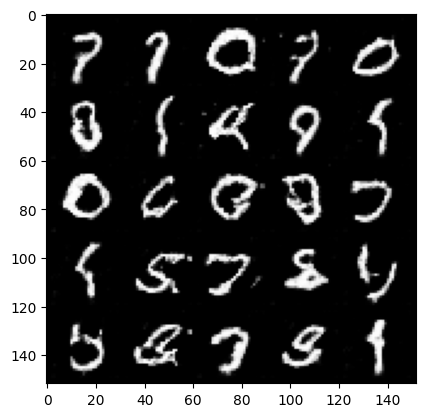

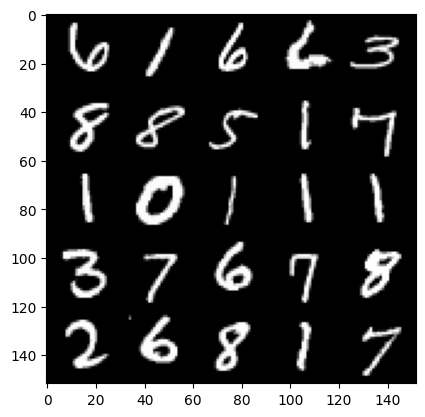

 91%|█████████▏| 429/469 [00:14<00:01, 30.89it/s]

Step 14500: Generator loss: 0.7113082257509233, discriminator loss: 0.6942124127149583


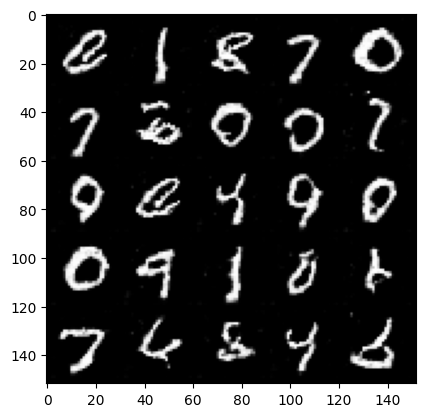

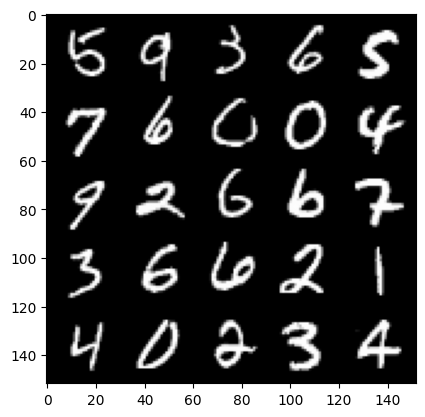

 98%|█████████▊| 461/469 [00:15<00:00, 30.54it/s]

Step 15000: Generator loss: 0.7145703163743017, discriminator loss: 0.6954135936498648


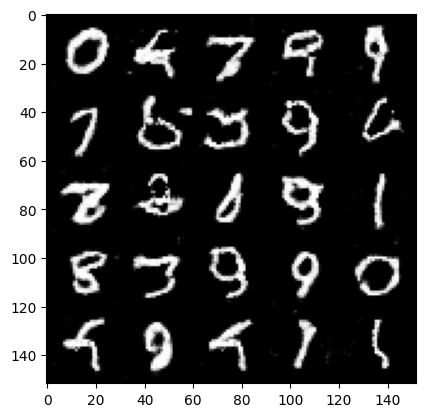

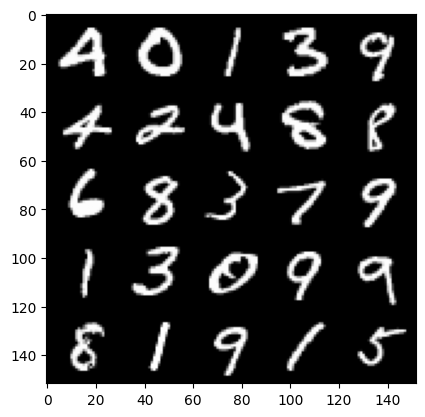

  5%|▍         | 22/469 [00:00<00:14, 30.89it/s]

Step 15500: Generator loss: 0.7098416719436652, discriminator loss: 0.6958276751041419


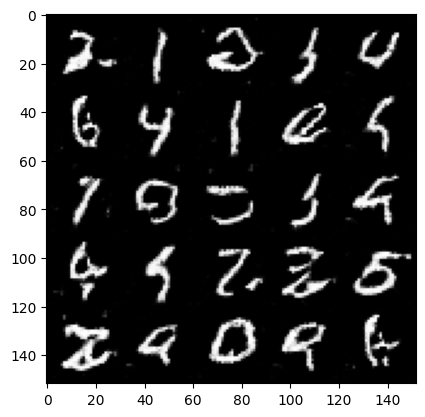

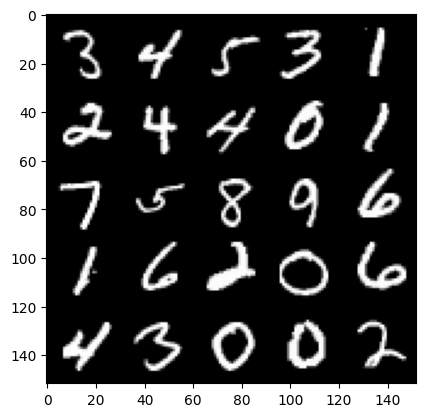

 12%|█▏        | 54/469 [00:01<00:13, 30.93it/s]

Step 16000: Generator loss: 0.7073301739692694, discriminator loss: 0.6956673953533178


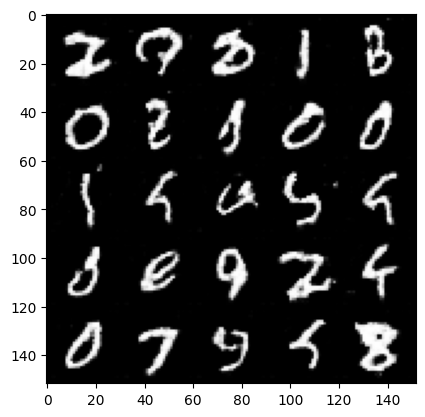

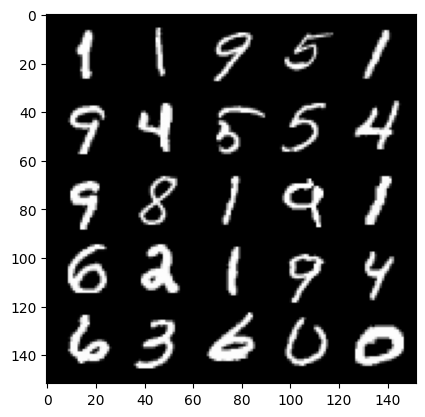

 18%|█▊        | 83/469 [00:02<00:12, 30.74it/s]

Step 16500: Generator loss: 0.7096154520511624, discriminator loss: 0.6950188938379287


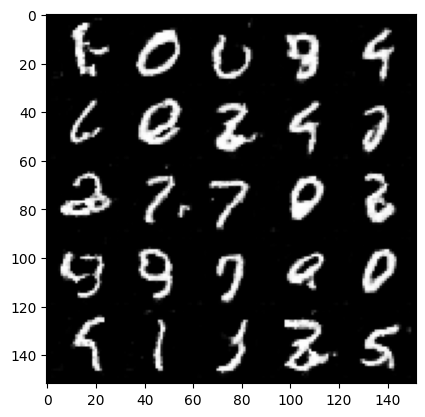

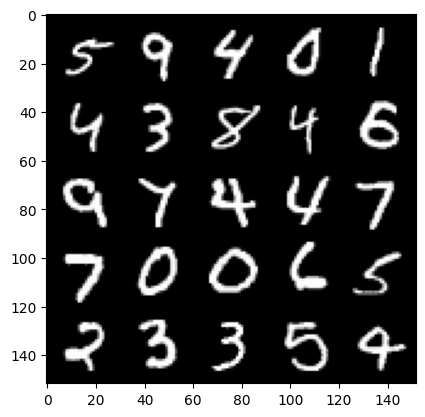

 24%|██▍       | 114/469 [00:03<00:11, 31.25it/s]

Step 17000: Generator loss: 0.707102926909924, discriminator loss: 0.6970156801939016


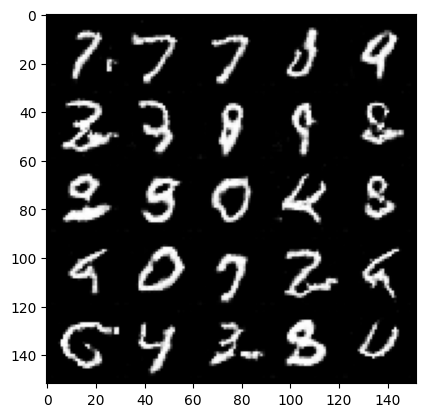

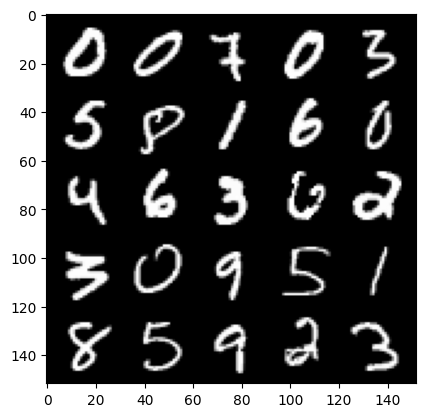

 31%|███▏      | 147/469 [00:04<00:10, 29.77it/s]

Step 17500: Generator loss: 0.7078590334057806, discriminator loss: 0.6961935595273974


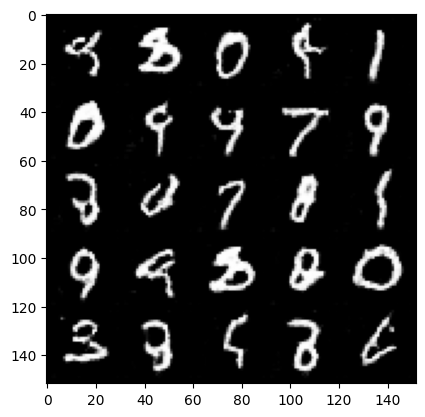

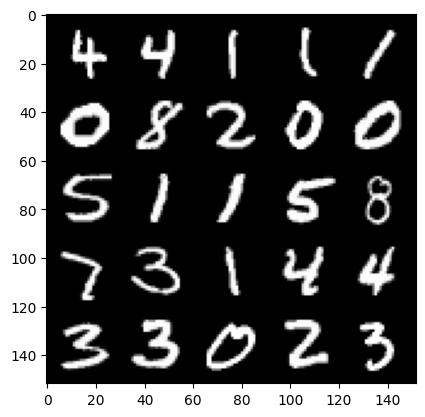

 38%|███▊      | 177/469 [00:06<00:10, 27.65it/s]

Step 18000: Generator loss: 0.7053464321494103, discriminator loss: 0.6947528429031373


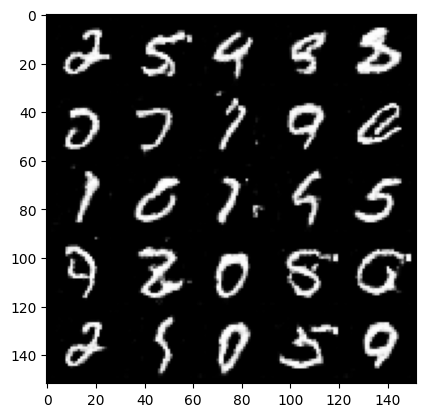

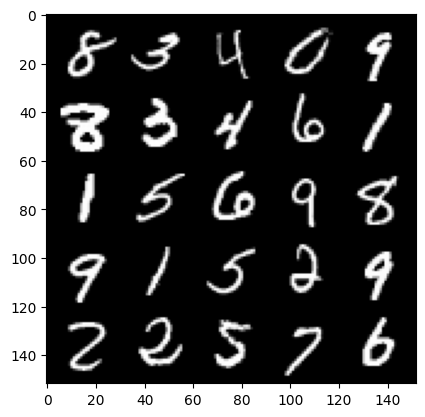

 45%|████▍     | 209/469 [00:07<00:08, 29.25it/s]

Step 18500: Generator loss: 0.7079750124812123, discriminator loss: 0.6956320620775226


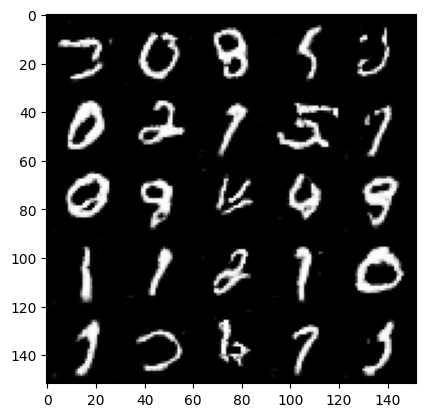

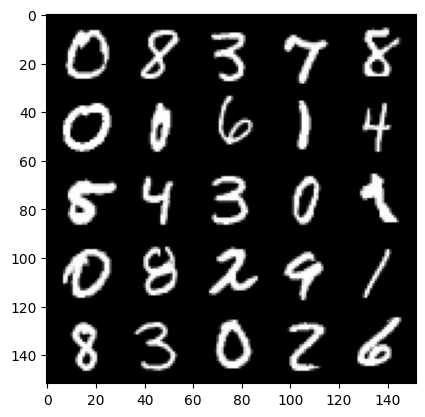

 51%|█████     | 239/469 [00:08<00:08, 28.28it/s]

Step 19000: Generator loss: 0.7054219012260442, discriminator loss: 0.6995435431003568


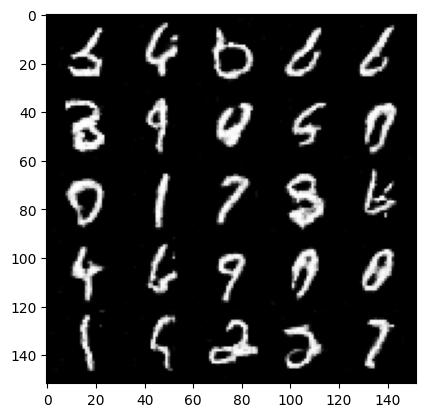

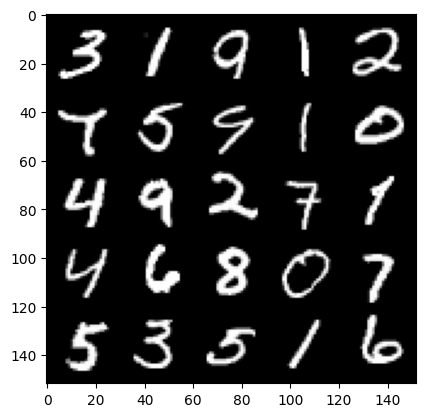

 57%|█████▋    | 269/469 [00:09<00:06, 29.21it/s]

Step 19500: Generator loss: 0.6994549009799946, discriminator loss: 0.6963699181079872


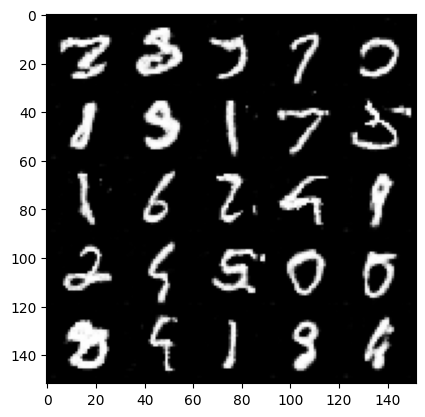

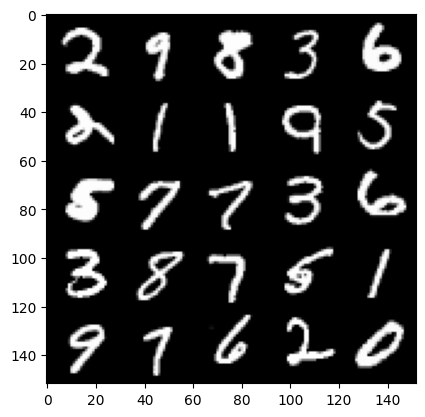

 64%|██████▍   | 301/469 [00:10<00:05, 28.27it/s]

Step 20000: Generator loss: 0.7048400275707247, discriminator loss: 0.6959957035779953


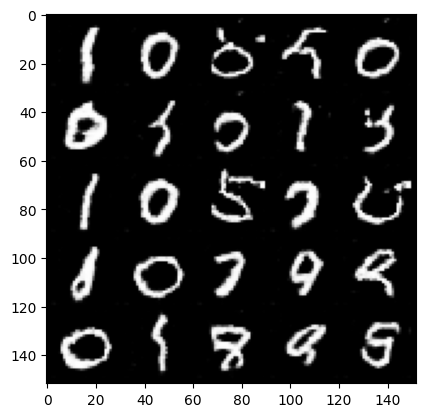

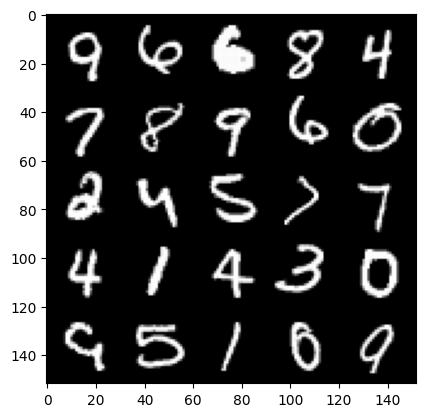

 71%|███████   | 333/469 [00:11<00:04, 28.32it/s]

Step 20500: Generator loss: 0.7062200670838352, discriminator loss: 0.695563344836235


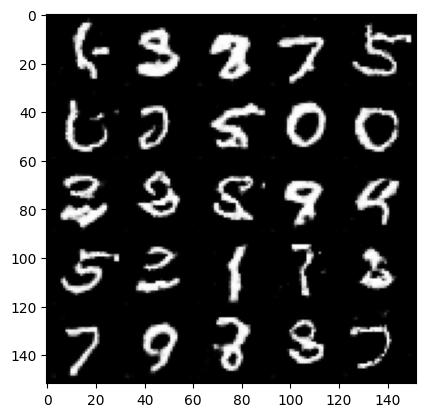

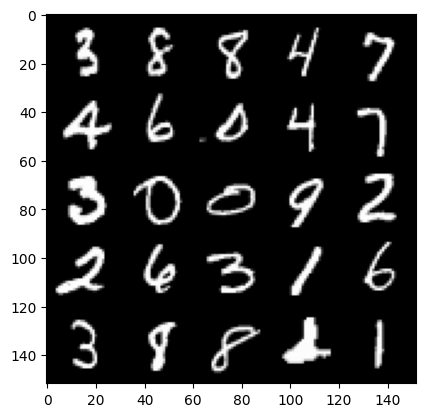

 77%|███████▋  | 363/469 [00:12<00:03, 28.61it/s]

Step 21000: Generator loss: 0.7044156719446182, discriminator loss: 0.6953830579519278


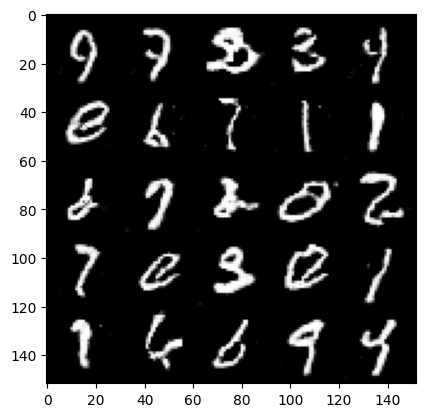

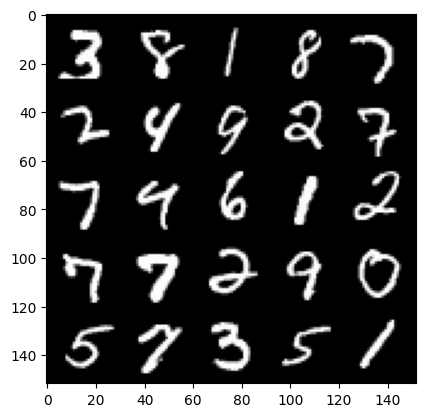

 84%|████████▍ | 393/469 [00:14<00:02, 28.56it/s]

Step 21500: Generator loss: 0.705117123305798, discriminator loss: 0.6952894251346587


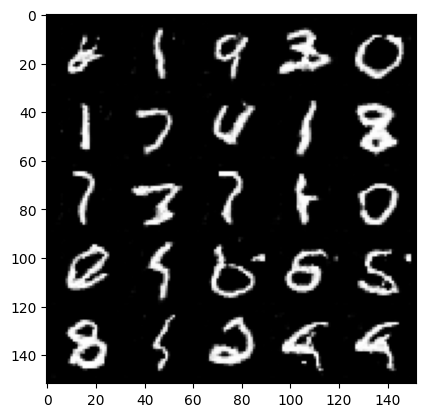

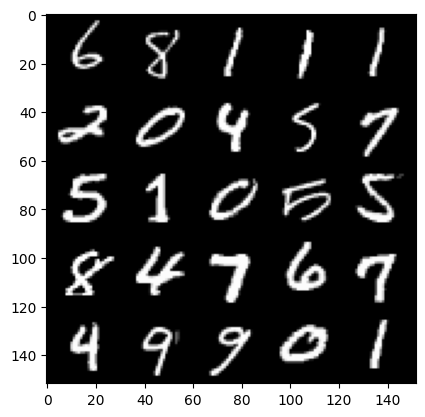

 91%|█████████ | 425/469 [00:14<00:01, 29.21it/s]

Step 22000: Generator loss: 0.7048906066417696, discriminator loss: 0.6947452299594876


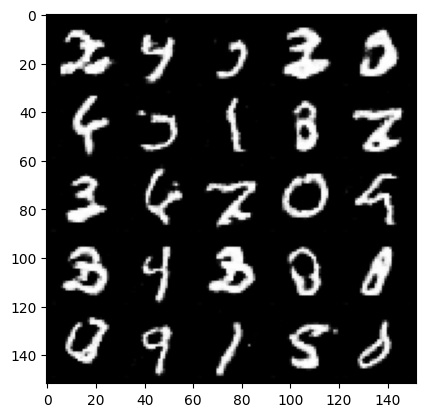

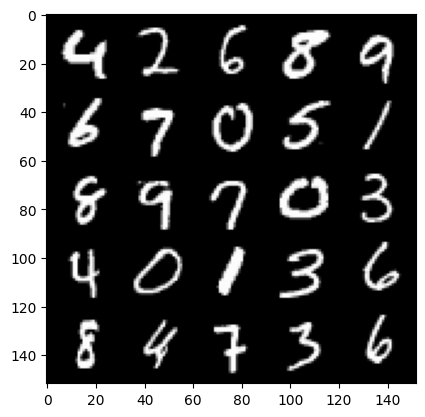

 97%|█████████▋| 457/469 [00:15<00:00, 30.14it/s]

Step 22500: Generator loss: 0.7048391383290292, discriminator loss: 0.6950925717353822


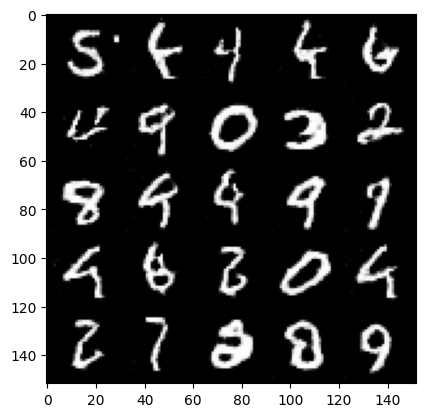

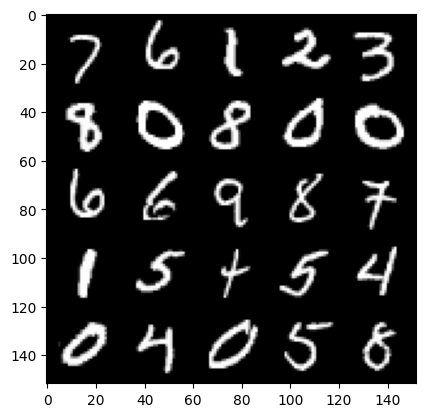

  4%|▍         | 18/469 [00:00<00:16, 27.30it/s]

Step 23000: Generator loss: 0.7033136850595473, discriminator loss: 0.6947510334253306


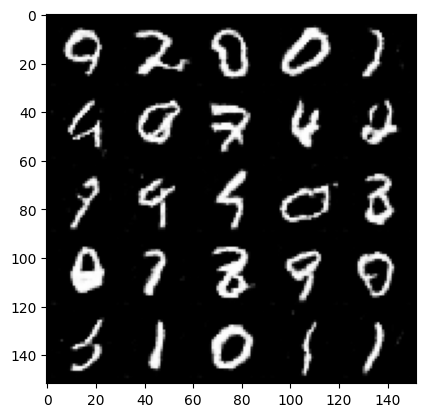

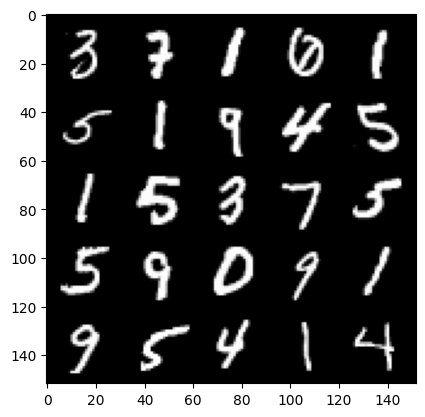

100%|██████████| 469/469 [00:16<00:00, 28.41it/s]


In [10]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


In [15]:
#save the gan model in a folder caled models
#create the folder if it does not exist
import os
if not os.path.exists('models'):
    os.makedirs('models')
# torch.save(disc.state_dict(), 'models/gan_discriminator.pth')
torch.save(gen.state_dict(), 'models/gan_generator.pth')

In [11]:
z_noise=get_noise(1,64).to(device)
fake=gen(z_noise)

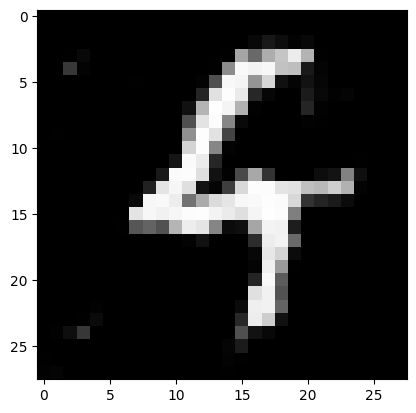

In [12]:
show_tensor_images(fake)

In [13]:
# create a space in huggingface to save the model

gen.save_pretrained('gan_model')
disc.save_pretrained('gan_model')
#use it as a pipeline
from transformers import pipeline
from transformers import GANPipeline


AttributeError: 'Generator' object has no attribute 'save_pretrained'